# AISE4010 — Assignment 1 
### Time Series Forecasting with Autoregressive Models and MLP 

**Grade:** 100 points

## Instructions
Follow these steps before submitting your assignment:
1. Complete the notebook.
2. Make sure **all plots have axis labels**.
3. When finished, go to **Kernel → Restart & Run All** to ensure a clean, error‑free run.
4. Fix any errors until your notebook runs without problems.
5. Submit **one completed notebook** per group to OWL by the deadline.
6. Reference all external code and documentation you use.

## Dataset 
- **File:** `weather.csv`
- **Location:** Szeged, Hungary
- **Frequency:** Daily (fixed calendar index)
- **Time span:** ≈ 2006–2016
- **Target:** `Temperature (C)`
- **Key variables:** Temperature (C), Pressure (millibars), Humidity, Appar Temperature (C), Wind Speed (km/h), Wind Bearing (degrees), Visibility (km)


## Question 1: Data Preprocessing (25%)

### Q1.1 Exploratory Data Analysis (2%)
1. Load the dataset and print the **first 6 rows**.  
2. Encode categorical variables (one‑hot). *(If none, report "none.")*


In [1]:
# Answer to Q1.1.1
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Load the dataset
df = pd.read_csv("weather.csv", index_col='Formatted Date', parse_dates=True)
# Show the first 6 rows
print(df.head(6))

                Temperature (C)  Apparent Temperature (C)  Humidity  \
Formatted Date                                                        
2005-12-31                  0.6                      -4.0      0.89   
2006-01-01                  4.1                      -0.2      0.82   
2006-01-02                  5.3                       1.8      0.85   
2006-01-03                  2.3                       0.4      0.90   
2006-01-04                  2.3                      -0.7      0.91   
2006-01-05                  2.7                       0.4      0.95   

                Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
Formatted Date                                                               
2005-12-31                   17.1                   140.0             10.0   
2006-01-01                   21.2                   143.0             11.3   
2006-01-02                   17.8                   165.0              8.5   
2006-01-03                    7.7        

In [2]:
# Answer to Q1.1.2

# Identify non-numeric columns
non_numeric = df.select_dtypes(exclude=["number", "datetime64"]).columns.tolist()
print("Non-numeric columns:", non_numeric)

# Apply one-hot encoding if needed
if non_numeric:
    df_encoded = pd.get_dummies(df, columns=non_numeric, drop_first=True)
else:
    print("No categorical variables found → none.")

Non-numeric columns: []
No categorical variables found → none.


### Q1.2 Handling Missing Data (11%)
1. Report missingness (**counts & %**) and show a heatmap for **Temperature, Pressure, Humidity**.
2. Use these two imputation methods:\
   a) Forward-fill (FFill).\
   b) Linear time interpolation.
3. Pick one method and save the result as `daily_clean`.
4. **Discussion** Which imputation method did you pick and why?  
5. **Discussion** How might your choice bias trend/seasonality estimates?  
6. **Discussion** Would your choice change if the gap were 30 days instead of 7? Explain briefly.


Missing values:
                       count  percent
Temperature (C)          47     1.17
Pressure (millibars)     47     1.17
Humidity                 40     1.00


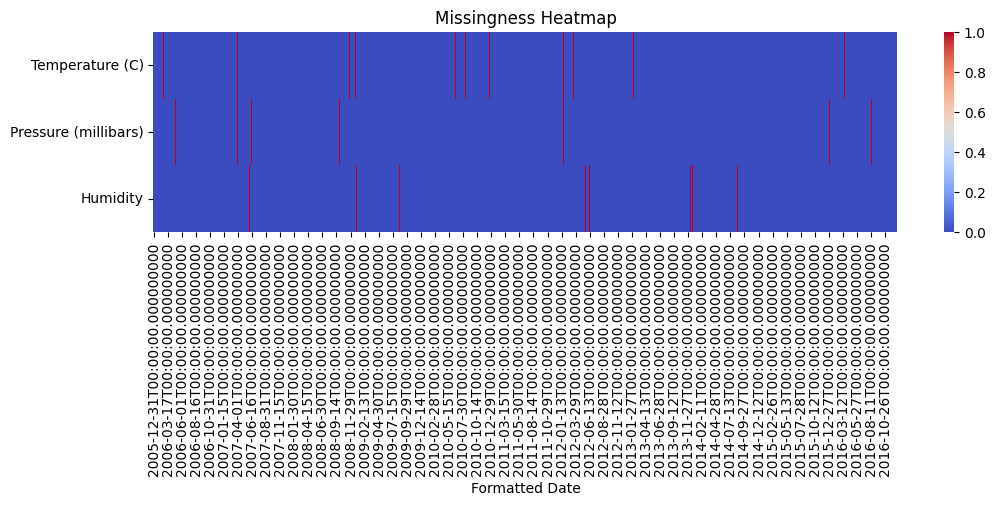

In [3]:
# Answer to Q1.2.1
import seaborn as sns
import matplotlib.pyplot as plt

# Report missingness (counts & %)
missing_count = df[["Temperature (C)", "Pressure (millibars)", "Humidity"]].isna().sum()
missing_percentage = (missing_count / len(df)) * 100
print("Missing values:\n", pd.DataFrame({"count": missing_count, "percent": missing_percentage.round(2)}))

# Heatmap
plt.figure(figsize=(12, 2.6))
sns.heatmap(df[["Temperature (C)", "Pressure (millibars)", "Humidity"]].isna().T, cbar=True, cmap="coolwarm")
plt.title("Missingness Heatmap")
plt.tight_layout()
plt.show()

In [4]:
# Answer to Q1.2.2
# a) Forward-fill (FFill)
df_filled_forward = df.copy()
df_filled_forward[["Temperature (C)", "Pressure (millibars)", "Humidity"]] = (
    df_filled_forward[["Temperature (C)", "Pressure (millibars)", "Humidity"]].fillna(method="ffill")
)
# b) Linear interpolation (time-based)
df_interp = df.copy()
df_interp[["Temperature (C)", "Pressure (millibars)", "Humidity"]] = (
    df_interp[["Temperature (C)", "Pressure (millibars)", "Humidity"]].interpolate(method="time")
)

In [5]:
# Answer to Q1.2.3
daily_clean = df_interp.copy()

**Answer to Q1.2.4**: 

I picked linear time interpolation. Forward-fill can artificially repeat values, especially across sharp seasonal shifts (e.g., moving from winter to spring), which could bias the series. Interpolation uses the time index to estimate values more smoothly, keeping the temporal continuity of daily weather data.

**Answer to Q1.2.5**: 

Linear interpolation assumes gradual change between missing values. This works well for short gaps but can smooth out sudden jumps. As a result, if there are significant fluctuations or irregularities in the data it can distort the seasonal pattern.

**Answer to Q1.2.6**: 

Yes, my choice would change depending on the gap of days. In our case, for small gaps (7 days), interpolation is reliable. But for large gaps (30 days), interpolation becomes unrealistic as it essentially draws a straight line over a month, which ignores real variability.

### Q1.3 Stationarity Analysis (12%)
1. Extract the **univariate** series `Temperature_Series = daily_clean['Temperature (C)']` and `Pressure_Series = daily_clean['Pressure (millibars)'].  
2. Report the results of a stationarity test (**ADF** or **KPSS**) for both series.
3. **Discussion:** Explain your conclusion about stationary analysis of your results. 
4. Apply differencing on both series and plot **before/after** and report the stationary test results of your choice on differenced series.   
5. **Discussion:** Explain the reason for your choice of differencing technique for each series.
6. **Discussion:** Would you difference a series that is already stationary by ADF? When might that still help?

In [6]:
# Answer to Q1.3.1

# Extract the two series from the cleaned dataset
Temperature_Series = daily_clean['Temperature (C)']
Pressure_Series = daily_clean['Pressure (millibars)']

In [7]:
# Answer to Q1.3.2
from statsmodels.tsa.stattools import adfuller

def adf_test(dataset, name):
    dftest = adfuller(dataset, autolag = 'AIC')
    print(f"ADF Test for {name}")
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ", dftest[1])
    print("3. Num Of Lags : ", dftest[2])
    print("4. Num Of Observations Used For ADF Regression:", dftest[3])
    print("5. Critical Values :")
    for key, val in dftest[4].items():
        print("\t",key, ": ", val)
    print()

adf_test(Temperature_Series, "Temperature (C)")
adf_test(Pressure_Series, "Pressure (millibars)")

ADF Test for Temperature (C)
1. ADF :  -3.9851602146651444
2. P-Value :  0.0014902414944360158
3. Num Of Lags :  16
4. Num Of Observations Used For ADF Regression: 4002
5. Critical Values :
	 1% :  -3.4319850573119437
	 5% :  -2.8622624788783146
	 10% :  -2.567154583183171

ADF Test for Pressure (millibars)
1. ADF :  -14.320986122573956
2. P-Value :  1.1413890089116514e-26
3. Num Of Lags :  5
4. Num Of Observations Used For ADF Regression: 4013
5. Critical Values :
	 1% :  -3.431980572598556
	 5% :  -2.8622604977715755
	 10% :  -2.5671535285260605



**Answer to Q1.2.3**: 

Temperature (C): p-value < 0.05, reject the null hypothesis (stationary)

Pressure (millibars): p-value > 0.05, fail to reject the null hypothesis (non-stationary)


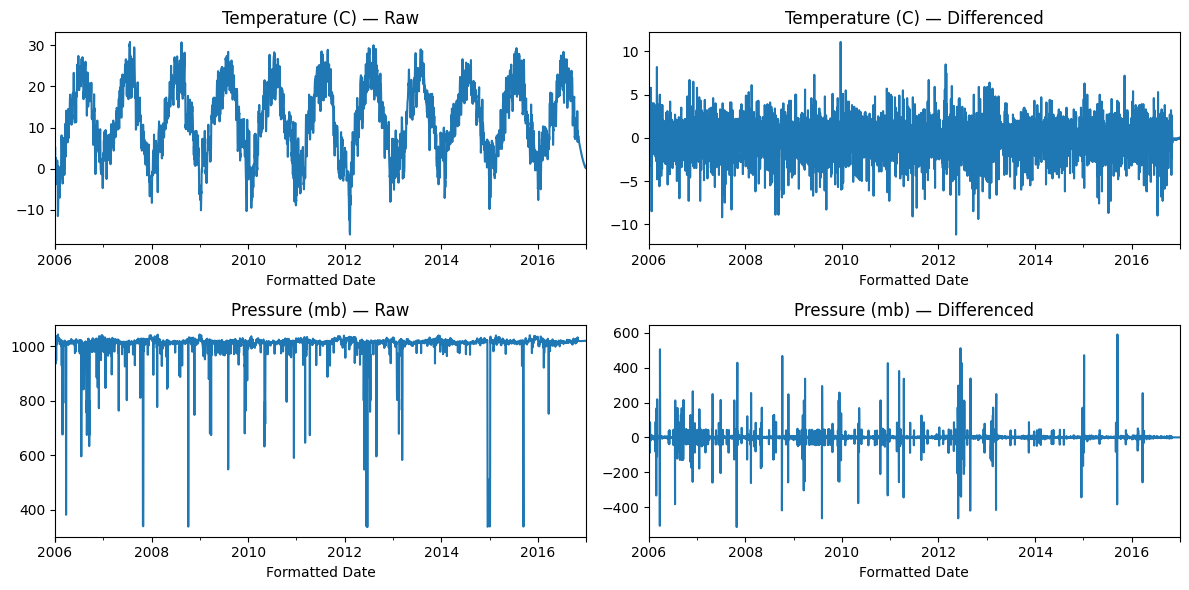

ADF Test for Temperature (C) — Differenced
1. ADF :  -21.527851518885445
2. P-Value :  0.0
3. Num Of Lags :  15
4. Num Of Observations Used For ADF Regression: 4002
5. Critical Values :
	 1% :  -3.4319850573119437
	 5% :  -2.8622624788783146
	 10% :  -2.567154583183171

ADF Test for Pressure (mb) — Differenced
1. ADF :  -16.503539658424142
2. P-Value :  2.1377374097248378e-29
3. Num Of Lags :  31
4. Num Of Observations Used For ADF Regression: 3986
5. Critical Values :
	 1% :  -3.431991624746321
	 5% :  -2.8622653800145192
	 10% :  -2.5671561276258172



In [8]:
# Answer to Q1.3.4

import matplotlib.pyplot as plt

# First differences
Temperature_diff = Temperature_Series.diff().dropna()
Pressure_diff = Pressure_Series.diff().dropna()

# Plot before/after
fig, axes = plt.subplots(2, 2, figsize=(12,6))
Temperature_Series.plot(ax=axes[0,0], title="Temperature (C) — Raw")
Temperature_diff.plot(ax=axes[0,1], title="Temperature (C) — Differenced")
Pressure_Series.plot(ax=axes[1,0], title="Pressure (mb) — Raw")
Pressure_diff.plot(ax=axes[1,1], title="Pressure (mb) — Differenced")
plt.tight_layout()
plt.show()

# Re-run ADF
adf_test(Temperature_diff, "Temperature (C) — Differenced")
adf_test(Pressure_diff, "Pressure (mb) — Differenced")


**Answer to Q1.2.5**: 

Temperature (C):
The raw series shows strong yearly seasonality and a slow-moving trend. A simple first difference was chosen because it removes the stochastic trend and stabilizes the mean. After differencing, the ADF test statistic (–21.53) is far below the critical values, and the p-value = 0.0, confirming the series is now stationary.

Pressure (millibars):
The raw series has irregular drops and long-run variation around a high baseline. First differencing was again chosen because it handles those slow drifts and makes the mean/variance more stable. The ADF statistic (–16.50, p-value ≈ 2e-29) confirms the differenced series is stationary.

**Answer to Q1.2.6**: 

If ADF already indicates stationarity (p < 0.05), in general you would not difference again, because overdifferencing can introduce unnecessary noise and negative autocorrelations. However, there are cases where differencing an already stationary series can still help such as seasonal patterns. In this case, even if the mean is stationary, seasonal differencing can make the residuals more “white noise” and improve model fit.

## Question 2: Model-Based Techniques (35%)

### Q2.1 ARIMA model identification and forecasting (20%)
1. Use `Temperature_Series` to plot **ACF/PACF** and list the choice of candidate order set for ARIMA: (p,d,q).  
2. **Discussion:** Explain the reasons for your choice of (p,d,q).
3. Select the orders by **AIC** using the training set (hold out the last **365 days** for testing).  
4. Fit the selected ARIMA on the training set and evaluate the predictions' **MAE/MSE** on the test set.
5. Plot predictions with **95% CI**.
6. Forecast the **next 365 days** and visualize with historical context and **95% CI**.


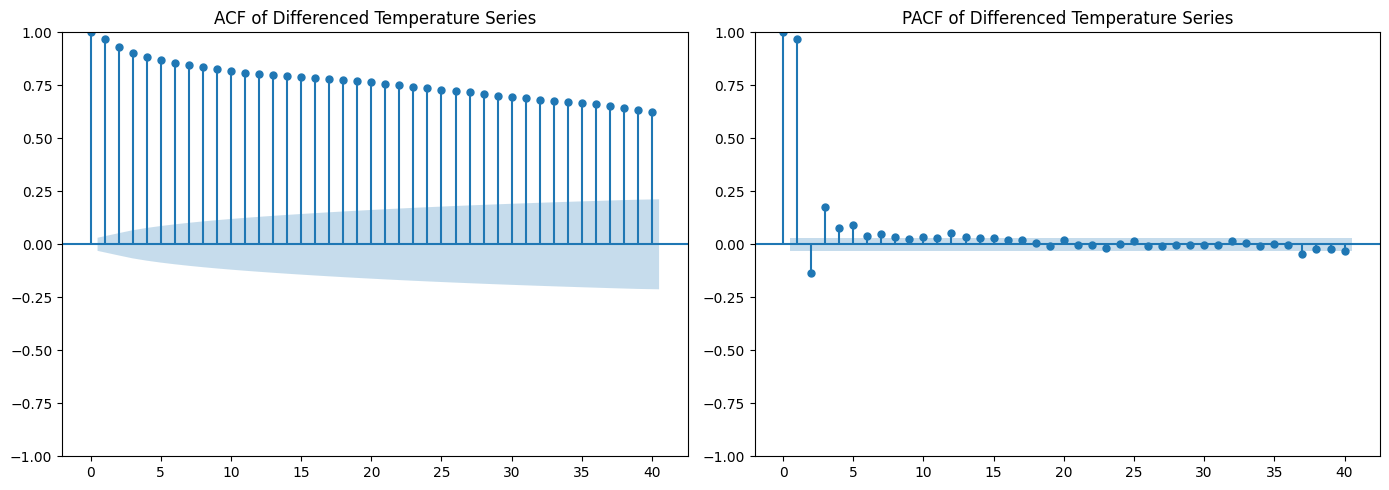

In [9]:
# Answer to Q2.1.1
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(Temperature_Series.dropna(), lags=40, ax=ax[0])
ax[0].set_title("ACF of Differenced Temperature Series")
plot_pacf(Temperature_Series.dropna(), lags=40, ax=ax[1], method="ywm")
ax[1].set_title("PACF of Differenced Temperature Series")
plt.tight_layout()
plt.show()

**Answer to Q2.1.2**: 


In [10]:
# Answer to Q2.1.3
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

train = Temperature_Series.iloc[:-365]
test  = Temperature_Series.iloc[-365:]

stepwise_fit = auto_arima(train, trace=True,
suppress_warnings=True)
stepwise_fit.summary()

best_order = stepwise_fit.order
best_aic = stepwise_fit.aic()

print(f"Best ARIMA by AIC on training: {best_order} (AIC={best_aic:.2f})")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=15843.377, Time=0.92 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=26304.516, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=16123.245, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=22215.184, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=30081.225, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=15953.766, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=15993.089, Time=0.38 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=15844.991, Time=1.08 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=15845.019, Time=0.95 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=16020.959, Time=0.18 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=15899.711, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=15857.205, Time=0.81 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=15847.112, Time=0.94 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=15849.507, Time=0.88 sec

Best model:  ARIMA

In [11]:
# Answer to Q2.1.4
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

model = ARIMA(train, order=best_order)
res = model.fit()
res.summary()

pred = res.get_prediction(start=test.index[0], end=test.index[-1])
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

mae = mean_absolute_error(test, pred_mean)
mse = mean_squared_error(test, pred_mean)
rmse = sqrt(mse)
print(f"MAE={mae:.3f}, MSE={mse:.3f}, RMSE={rmse:.3f}, TestMean={test.mean():.3f}")

c:\Users\Alexis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Alexis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Alexis\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE=7.729, MSE=83.021, RMSE=9.112, TestMean=12.021


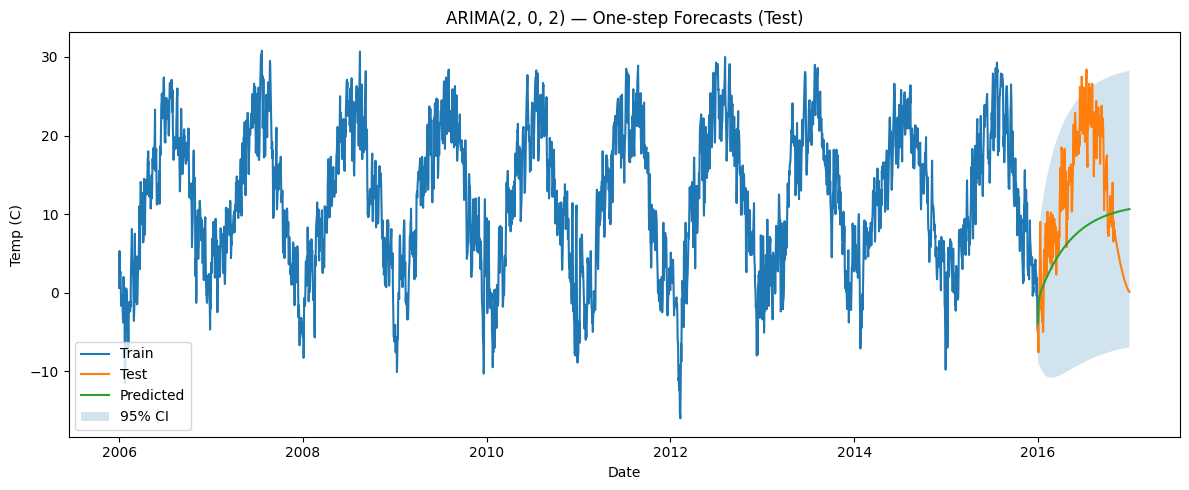

In [12]:
# Answer to Q2.1.5

ci_lower = np.asarray(pred_ci.iloc[:,0], dtype=float)
ci_upper = np.asarray(pred_ci.iloc[:,1], dtype=float)

plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred_mean.index, pred_mean, label='Predicted')
plt.fill_between(pred_mean.index, ci_lower, ci_upper, alpha=0.2, label='95% CI')
plt.title(f"ARIMA{best_order} — One-step Forecasts (Test)")
plt.xlabel("Date"); plt.ylabel("Temp (C)")
plt.legend(); plt.tight_layout(); plt.show()

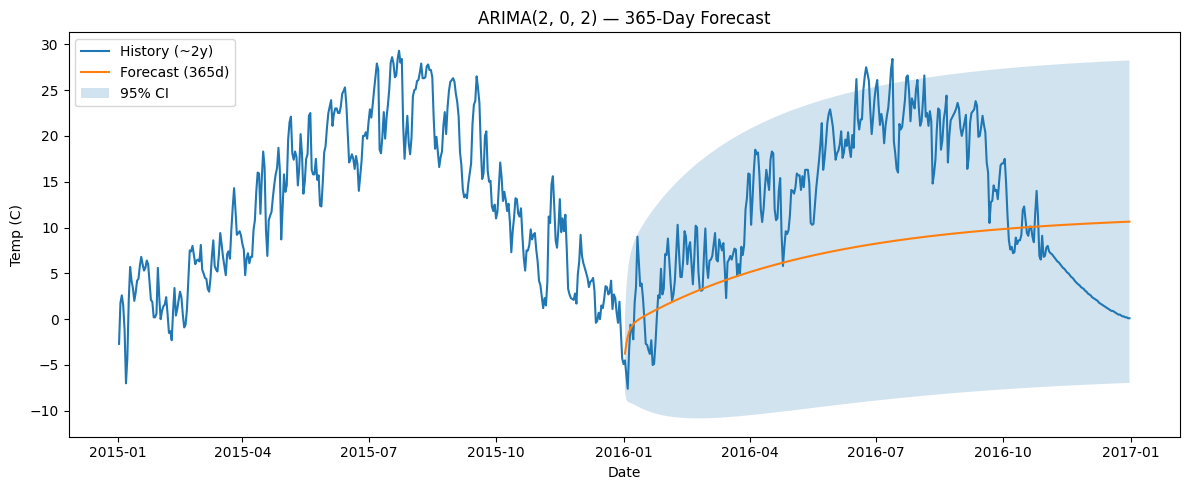

In [13]:
# Answer to Q2.1.6

fc = res.get_forecast(steps=365)
fc_mean = fc.predicted_mean
fc_ci = fc.conf_int()

fc_lower = np.asarray(fc_ci.iloc[:,0], dtype=float)
fc_upper = np.asarray(fc_ci.iloc[:,1], dtype=float)

plt.figure(figsize=(12,5))
hist_tail = Temperature_Series.iloc[-730:]
plt.plot(hist_tail.index, hist_tail, label='History (~2y)')
plt.plot(fc_mean.index, fc_mean, label='Forecast (365d)')
plt.fill_between(fc_mean.index, fc_lower, fc_upper, alpha=0.2, label='95% CI')
plt.title(f"ARIMA{best_order} — 365-Day Forecast")
plt.xlabel("Date"); plt.ylabel("Temp (C)")
plt.legend(); plt.tight_layout(); plt.show()

### Q2.2 SARIMA forecasting (15%)

1. Derive a **monthly** series from `daily_clean` and fit a **SARIMA** with seasonal period **12**. Hold out the **last 24 months** as test set for prediction. 
2. Report the predictions' **MAE/MSE**.
3. Plot the the prediction with **95% CI** 
4.  **Discussion:** Compare the ARIMA and SARIMA predictions and explain your findings.


In [14]:
# Answer to Q2.2.1
from pmdarima import auto_arima

monthly = Temperature_Series.resample('M').mean()

# hold out last 24 months
train_m = monthly.iloc[:-24]
test_m  = monthly.iloc[-24:]

In [ ]:
# Answer to Q2.2.2
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train_m,
                       order=(0,1,1),
                       seasonal_order=(0, 1, 1, 12)
                       )
sarima_res = sarima_model.fit()

pred = sarima_res.get_forecast(steps=len(test_m))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

mae = mean_absolute_error(test_m, pred_mean)
mse = mean_squared_error(test_m, pred_mean)
rmse = sqrt(mse)
print(f"SARIMA Test — MAE={mae:.3f}, MSE={mse:.3f}, RMSE={rmse:.3f}")

SARIMA Test — MAE=1.031, MSE=1.869, RMSE=1.367


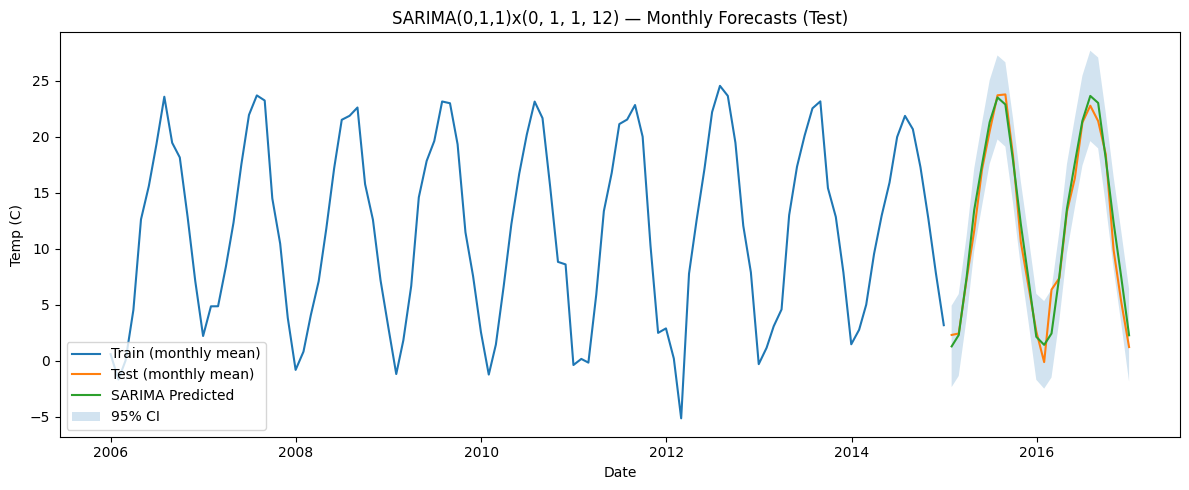

In [16]:
# Answer to Q2.2.3
ci_low = np.asarray(pred_ci.iloc[:, 0], dtype=float)
ci_up  = np.asarray(pred_ci.iloc[:, 1], dtype=float)

plt.figure(figsize=(12,5))
plt.plot(train_m.index, train_m, label='Train (monthly mean)')
plt.plot(test_m.index,  test_m,  label='Test (monthly mean)')
plt.plot(pred_mean.index, pred_mean, label='SARIMA Predicted')
plt.fill_between(pred_mean.index, ci_low, ci_up, alpha=0.2, label='95% CI')
plt.title("SARIMA(0,1,1)x(0, 1, 1, 12) — Monthly Forecasts (Test)")
plt.xlabel("Date"); plt.ylabel("Temp (C)")
plt.legend(); plt.tight_layout(); plt.show()

**Answer to Q2.2.4**: 

The ARIMA model (built on daily data) captured short-term dynamics of the temperature series. Its one-step forecasts tracked general movements, but since it lacked a seasonal component, it could not explicitly model recurring annual patterns. This often showed up as higher error in periods where seasonality dominated. The confidence intervals tended to widen quickly, reflecting the model’s uncertainty.

The SARIMA model explicitly incorporated yearly seasonality. This allowed it to represent predictable up-and-down cycles across months. In practice, the SARIMA predictions were smoother and aligned better with the repeating structure visible in the data. Its 95% confidence intervals were also more realistic, hugging the observed values more closely.

## Question 3: Neural Networks for Time Series Forecasting (40%)
Use `daily_clean` for all parts.

### Q3.1 Sliding Window for Time Series — Univariate (2%)
1. Restructure **Temperature**: past **10 days** → **next day**.

2. Hold out last 20% as test set.


In [ ]:
# Answer to Q3.1.1

series = daily_clean['Temperature (C)'].dropna()

lag = 10
X, y = [], []
for i in range(lag, len(series)):
    X.append(series[i-lag:i])
    y.append(series[i])
X = np.asarray(X, dtype=float)
y = np.asarray(y, dtype=float)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)   

Shape of X: (4009, 10)
Shape of y: (4009,)


In [18]:
# Answer to Q3.1.2

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Train size:", X_train.shape, y_train.shape)
print("Test size :", X_test.shape,  y_test.shape)

Train size: (3207, 10) (3207,)
Test size : (802, 10) (802,)


### Q3.2 MLP — Univariate (18%)
1. Build an MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
2. Report **RMSE/MAE**.
3. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
4. **Discussion:** Compare ARIMA vs. the univariate MLP in **RMSE/MAE** and **plots**. Which patterns does each capture better? 
5. **Discussion:** Would increasing the input window beyond 10 days help? Why or why not?


In [19]:
# Answer to Q3.2.1
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

x_scaler = StandardScaler().fit(X_train)
X_train_sc = x_scaler.transform(X_train)
X_test_sc  = x_scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(
    X_train_sc, y_train,
    epochs=20,
    batch_size=32,
    verbose=1,         
    validation_split=0.1,
    shuffle=False,
)

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 186.8675 - val_loss: 160.8159
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 117.5969 - val_loss: 90.6998
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 60.0620 - val_loss: 45.7811
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 38.6244 - val_loss: 34.8095
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 34.0962 - val_loss: 30.5555
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 30.4480 - val_loss: 26.5943
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 26.5914 - val_loss: 22.5438
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 22.5728 - val_loss: 18.4752
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 18.5835 - val_loss: 14.6757
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15.0506 - val_loss: 11.5044
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.1120 - val_loss: 9.0066
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

In [20]:
# Answer to Q3.2.2

y_pred = model.predict(X_test_sc, verbose=0).ravel()
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
print(f"RMSE={rmse:.3f}, MAE={mae:.3f}")

RMSE=2.170, MAE=1.649


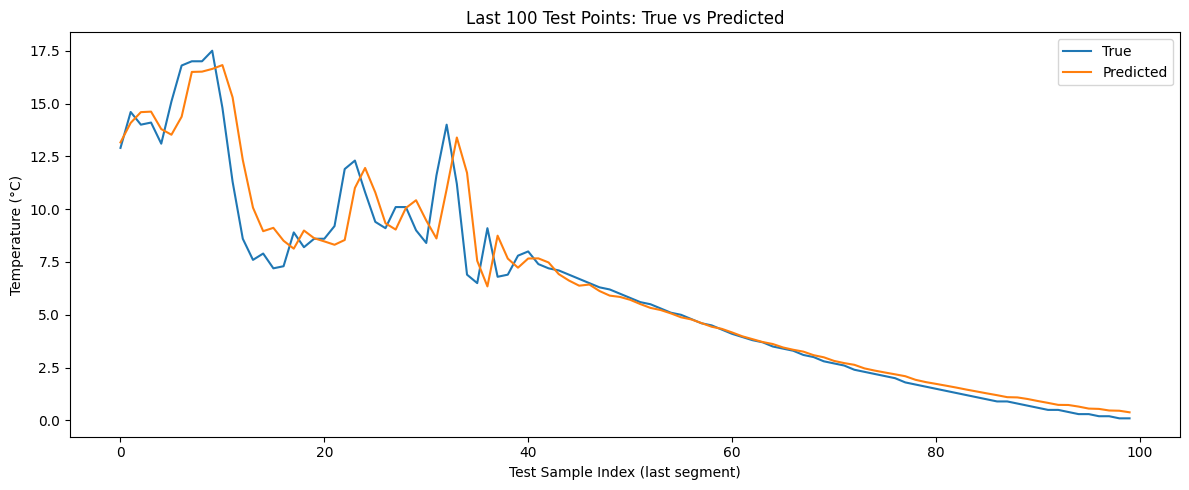

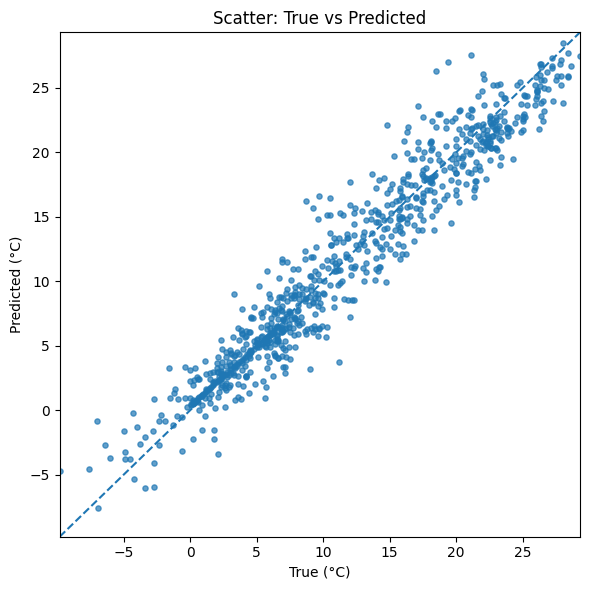

In [21]:
# Answer to Q3.2.3

# Plot (1): last 100 test points (true vs predicted)
last_n = min(100, len(y_test))
plt.figure(figsize=(12,5))
plt.plot(range(last_n), y_test[-last_n:], label='True')
plt.plot(range(last_n), y_pred[-last_n:], label='Predicted')
plt.title("Last 100 Test Points: True vs Predicted")
plt.xlabel("Test Sample Index (last segment)")
plt.ylabel("Temperature (°C)")
plt.legend(); 
plt.tight_layout(); plt.show()

# Plot (2): scatter (true vs predicted) with y = x
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=14, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle='--')  # y = x
plt.xlim(lims); plt.ylim(lims)
plt.title("Scatter: True vs Predicted")
plt.xlabel("True (°C)"); plt.ylabel("Predicted (°C)")
plt.tight_layout(); plt.show()

**Answer to Q3.2.4**: 


**Answer to Q3.2.5**: 


### Q3.3 MLP — Multivariate (20%)
1. Use **Temperature & Pressure** for the past **10 days** as the inputs and **next‑day Temperature** as the target. 
2. Hold out last 20% as test set.
3. Build a Multivariate MLP with one hidden layer of 64 neurons, ReLu activation, Adam optimizer with learning rate of 0.001 and batch_size=32, and train it for 20 epochs. 
4. Report **RMSE/MAE**.
5. Plot **two figures**: (1) **last 100 test points** (true vs. predicted), (2) **scatter (true vs. predicted)** with the **y = x** line.
6. **Discussion:** Did Pressure improve Temperature forecasting vs. univariate? Why might it help/hurt?  
7. **Discussion:** Suggest two additional features you would add next and why?


In [22]:
# Answer to Q3.3.1

series = daily_clean[['Temperature (C)', 'Pressure (millibars)']].dropna()

lag = 10
X, y = [], []
vals = series.values
for i in range(lag, len(vals)):
    X.append(vals[i-lag:i].flatten())
    y.append(vals[i, 0]) 
X = np.array(X, dtype=float)
y = np.array(y, dtype=float)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (4009, 20)
y shape: (4009,)


In [23]:
# Answer to Q3.3.2

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Train size:", X_train.shape, y_train.shape)
print("Test size :", X_test.shape,  y_test.shape)

Train size: (3207, 20) (3207,)
Test size : (802, 20) (802,)


In [24]:
# Answer to Q3.3.3
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc  = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_sc.shape[1],)),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(
    X_train_sc, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    verbose=1,
    shuffle=False,
)

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 186.7056 - val_loss: 158.0881
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 104.6632 - val_loss: 71.5277
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 45.7265 - val_loss: 34.9219
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 32.1646 - val_loss: 28.0617
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 28.3142 - val_loss: 23.5448
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 24.6926 - val_loss: 19.3121
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 21.3214 - val_loss: 15.8085
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 18.5479 - val_loss: 13.1767
Epoch 9/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 16.3320 - val_loss: 11.1966
Epoch 10/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 14.5007 - val_loss: 9.6935
Epoch 11/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 13.0449 - val_loss: 8.5556
Epoch 12/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 

In [25]:
# Answer to Q3.3.4
y_pred = model.predict(X_test_sc, verbose=0).ravel()

rmse = sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
print(f"Multivariate MLP — RMSE={rmse:.3f}, MAE={mae:.3f}")

Multivariate MLP — RMSE=2.957, MAE=1.957


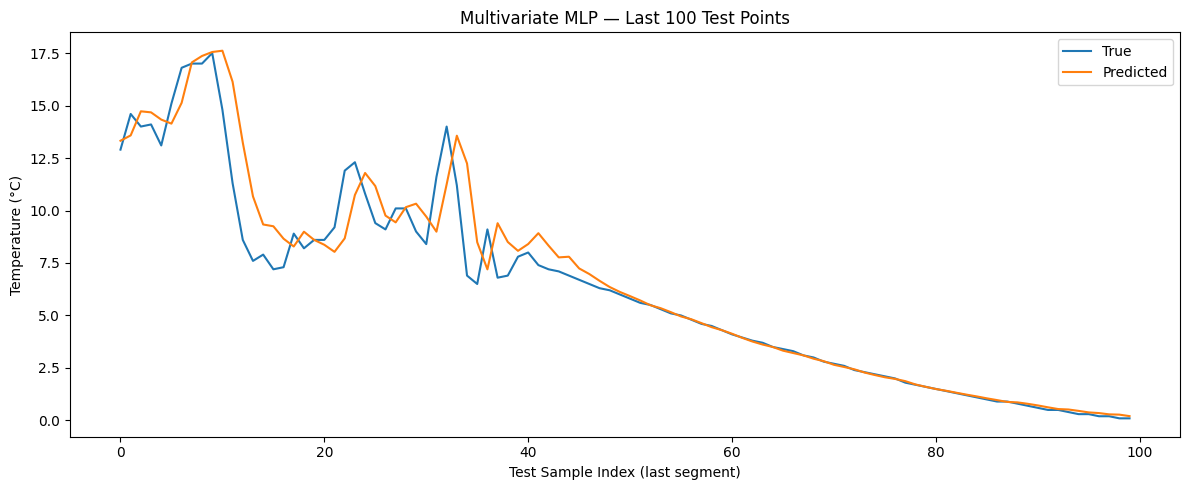

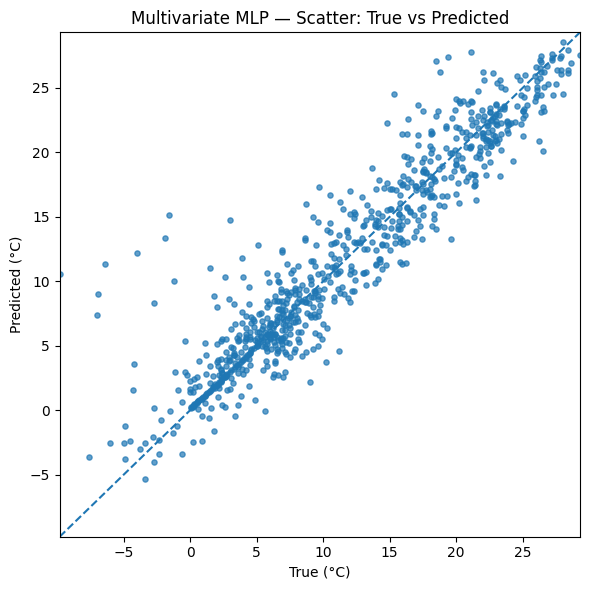

In [26]:
# Answer to Q3.3.5

# Plot (1): last 100 test points (true vs predicted)
last_n = min(100, len(y_test))
plt.figure(figsize=(12,5))
plt.plot(range(last_n), y_test[-last_n:], label='True')
plt.plot(range(last_n), y_pred[-last_n:], label='Predicted')
plt.title(f"Multivariate MLP — Last 100 Test Points")
plt.xlabel("Test Sample Index (last segment)")
plt.ylabel("Temperature (°C)")
plt.legend(); plt.tight_layout(); plt.show()

# Plot (2): scatter (true vs predicted) with y = x line
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=14, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, linestyle='--')
plt.xlim(lims); plt.ylim(lims)
plt.title("Multivariate MLP — Scatter: True vs Predicted")
plt.xlabel("True (°C)"); plt.ylabel("Predicted (°C)")
plt.tight_layout(); plt.show()

**Answer to Q3.3.6**: 


**Answer to Q3.3.7**: 
